# Storm Tracking Via Tree Structure Representation of Radar Data

 #### Hou-Wang 2017 

 #### Los datos y las librerías necesarias
 

In [281]:
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro de la misma Notebook, no en una ventana
## Solo para notebooks.
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import glob
import pyart
import scipy.io as sio



In [282]:
path_user = './'
FileList = np.sort(glob.glob(path_user+'*.nc'))
file2read=FileList[0]
print(file2read)

# Creamos el objeto "radar"
radar = pyart.io.read(file2read)

./cfrad.20110115_182004.000_to_20110115_182424.000_ANG_v19_SUR.nc


### Uso los datos de la primera elevación.

In [283]:
nelev=0

start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

rango  = radar.range['data']
tiempo = radar.time['data'][start_index:end_index]

# Sitio radar
lat_radar = radar.latitude['data'][0]
lon_radar = radar.longitude['data'][0]

# Datos de lat/lon
lats = radar.gate_latitude['data'][start_index:end_index]
lons = radar.gate_longitude['data'][start_index:end_index]

# Datos x/y (en metros)
xdist = radar.gate_x['data'][start_index:end_index]/1000.
ydist = radar.gate_y['data'][start_index:end_index]/1000.

# Variables radar
Zh  = radar.fields['dBZ']['data'][start_index:end_index, :]

In [284]:
type(radar)

pyart.core.radar.Radar

In [285]:
# mask out last 10 gates of each ray, this removes the "ring" around th radar.
radar.fields['dBZ']['data'][:, -10:] = np.ma.masked

# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('dBZ')

In [286]:
# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    (radar,), gatefilters=(gatefilter, ),
    grid_shape=(1, 480, 480),
    grid_limits=((0, 0), (-240000.0, 240000.0), (-240000.0, 240000.0)),
    fields=['dBZ'])

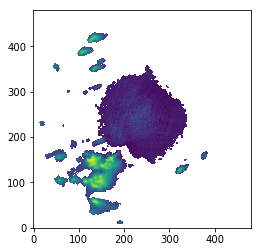

In [287]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(grid.fields['dBZ']['data'][0], origin='lower')
plt.show()

Ya tengo la información del radar en una grilla de aproximadamente 1kmx1km. Quiero poder recuperar la información de cada celda.

In [288]:
x=grid.x['data']
y=grid.y['data']
n=x.size

/home/mailen/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/home/mailen/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


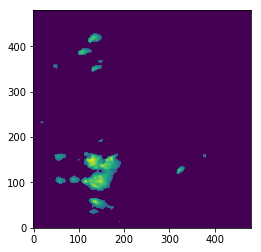

In [289]:
Ze = grid.fields['dBZ']['data'][0]
Zef = np.zeros(Ze.shape)
#Filtro de mediana 3x3 pixel

for i in range(1,n-1):
    for j in range(1,n-1):
        indice=np.ravel_multi_index((i,j),Ze.shape)
        
        ind1=Ze[i-1,j-1]
        ind2=Ze[i,j-1]
        ind3=Ze[i+1,j+1]
        ind4=Ze[i-1,j]
        ind6=Ze[i+1,j]
        ind7=Ze[i-1,j+1]
        ind8=Ze[i,j+1]
        ind9=Ze[i+1,j+1]
        
        neig=[ind1, ind2, ind3, ind4, ind6, ind7, ind8, ind9]
                                   
        med=np.median(neig)
        
        if med>20:
            Zef[i,j]= np.median(neig)
        else:
            Zef[i,j]= 0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Zef, origin='lower')
plt.show()

### Definición de los árboles

Primero se eligen los umbrales


In [309]:

maximo=int(np.max(Zef) - 5)

umb=np.linspace(20,maximo,num=5)
cp=umb.size-1

In [291]:
capa=[np.zeros(Ze.shape),np.ones(Ze.shape),np.zeros(Ze.shape),np.zeros(Ze.shape),np.zeros(Ze.shape)]
capa[0]


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [292]:
#Consigo las Pi
capa_aux = np.zeros(Ze.shape)
for t in range(0,umb.size):
    
    for i in range(1,n-1):
        for j in range(1,n-1):
            med=Zef[i,j]
            if med<umb[t]:
                capa_aux[i,j] = 0
            else:
                capa_aux[i,j] = med
                
    capa[t] = capa_aux
    capa_aux = np.zeros(Ze.shape)
    
#    fig = plt.figure()
#    ax = fig.add_subplot(111)
#    ax.imshow(capa[t], origin='lower')
#    plt.show()
    

#### Ahora puedo identificar las regiones usando un método de identificación de regiones. 
Robert Shapiro 1992

1. Lo paso a binario

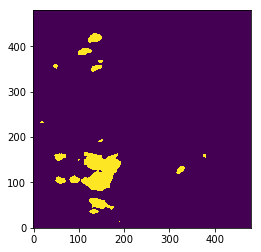

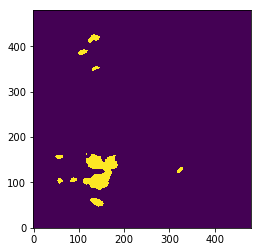

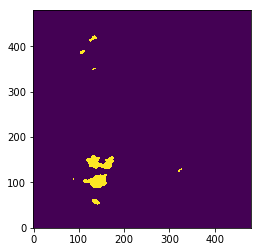

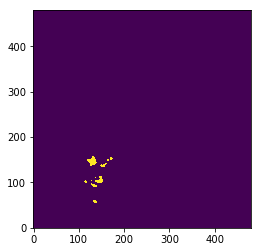

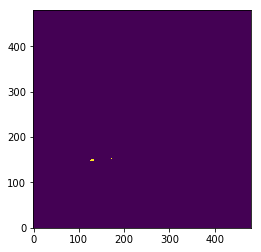

In [294]:
capa_bin = [np.zeros(Ze.shape),np.zeros(Ze.shape),np.zeros(Ze.shape),np.zeros(Ze.shape),np.zeros(Ze.shape)]
capa_aux = np.zeros(Ze.shape)
for t in range(0,umb.size):
    capa_actual=capa[t]
    for i in range(1,n-1):
        for j in range(1,n-1):
            med=capa_actual[i,j]
            if med != 0:
                capa_actual[i,j] = 1
            
                
    capa_bin[t] = capa_actual
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(capa[t], origin='lower')
    plt.show()


In [295]:
#colorido
muestra = capa_bin[2]
etiquetas = np.zeros(Ze.shape)
tag = 1

for i in range(1,n-1):
    
    for j in range(1,n-1):
        
        celda = muestra[i,j] 
        
        if celda != 0:
            etiquetas[i,j]=tag
            tag=tag+1
            
#Clasificación
cluster_in=np.unique(etiquetas).size
cluster_fin=0

dif=cluster_fin-cluster_in
print(dif)
counts = 0
while dif!=0:
    
    cluster_in=cluster_fin
    area = counts
    for i in range(1,n-1):
    
        for j in range(1,n-1):
        
            celda = etiquetas[i,j] 
        
            if celda != 0:
                
            
                vecinos = [etiquetas[i-1,j-1], etiquetas[i,j-1],etiquetas[i+1,j-1],
                           etiquetas[i-1,j],etiquetas[i+1,j],etiquetas[i-1,j+1], etiquetas[i,j+1], etiquetas[i+1,j+1]]
                buenos_vecinos= [x for x in vecinos if x != 0]
                
                if not buenos_vecinos :
                    tag=tag+1
                    
                else:
                    tag=min(buenos_vecinos)
                    
                    etiquetas[i,j]=tag
     
    unique, counts = np.unique(etiquetas, return_counts=True)
    cluster_fin=unique.size
    
    dif=cluster_fin-cluster_in
    #second check
    if dif == 0:
    
        dif=max(counts-area)
        
    

-2576


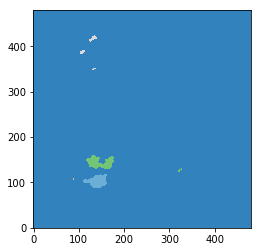

In [296]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(etiquetas, origin='lower', cmap='Vega20c')
plt.show()

Calculo el área de cada uno. Como usé que el área de los puntos es 1kmx1km solo tengo que contar la cantidad de celdas en el cluster

In [297]:
unique, counts = np.unique(etiquetas, return_counts=True)
unique = np.delete(unique,0)
area = np.delete(counts,0)


Genero la variable clusters que me guarda los índices de cada uno.

In [298]:
clusters = []

for i in range(0,unique.size):
    clusters.append(np.argwhere(etiquetas==unique[i]))




Calculo la intensidad media en cada cluster y centro

In [299]:
elementos = clusters[0]
x = 0
y = 0
media = []
centro = []
for i in range(0,unique.size):
    elementos=clusters[i]
    cantidad = elementos.shape[0]
    suma = 0
    xc = 0
    yc = 0
    for j in range(0,cantidad):
        
        x,y = elementos[j]
        xc = xc + x
        yc = yc + y
        suma = suma + Ze[x,y]
    centro.append([xc/cantidad,yc/cantidad])
    media.append(suma/cantidad)


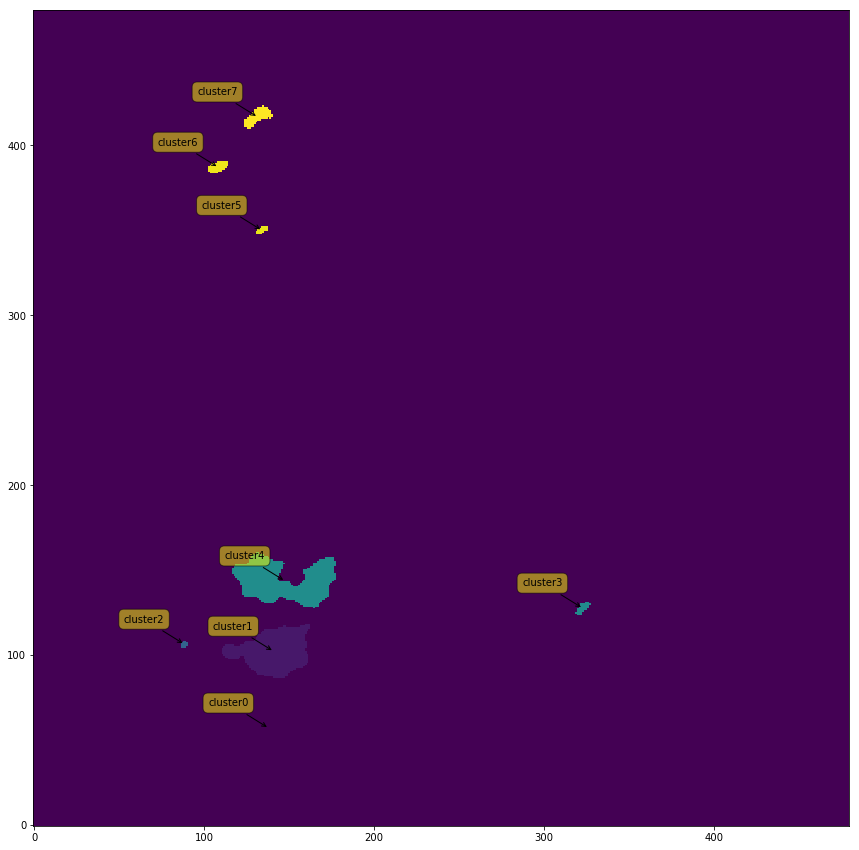

In [300]:
fig = plt.figure(figsize=[15,15])

ax = fig.add_subplot(111)
ax.imshow(etiquetas, origin='lower')
data = np.asarray(centro)
N = len(centro)
labels = ['cluster{0}'.format(i) for i in range(N)]

for label, x, y in zip(labels, data[:, 1], data[:, 0]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    

plt.show()

In [301]:
nodos.area

AttributeError: 'list' object has no attribute 'area'